In [ ]:
# 挂载google云盘
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
# 安装依赖
# 在colab中运行：pip install -r /content/drive/MyDrive/BraTS2021_Dataset/FinalProject/requirements.txt
# 加载本地py文件
import sys

# sys.path.append("/content/drive/MyDrive/BraTS2021_Dataset/FinalProject")
sys.path.append("/home/cserv1_a/soc_msc/ml20r2w/Documents/FinalProject")


# 加载data generator
# 加载图片 添加至np数组
def load_img(img_dir_path, img_name_list):
    images = []

    for i, img_name in enumerate(img_name_list):
        if img_name.split('.')[1] == 'npy':
            image = np.load(img_dir_path + img_name)
            images.append(image)

    images = np.array(images)
    return images


# 加载Batch
def image_loader(img_dir, img_list, mask_dir, mask_list, batch_size):
    list_length = len(img_list)

    # keras 要求的Generator需要可以无限迭代
    while True:
        batch_start = 0
        batch_end = batch_size
        # 取单个Batch
        while batch_start < list_length:
            limit = min(batch_end, list_length)
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])
            yield X, Y  # a tuple with two numpy arrays with batch_size samples
            # 下一组Batch的Cursor
            batch_start += batch_size
            batch_end += batch_size

In [2]:
# 数据集预处理
import configparser
import glob
import os.path
import nibabel as nib  # nii数据处理库
import numpy as np  # numpy数据处理
from sklearn.preprocessing import MinMaxScaler  # 正规化
import matplotlib.pyplot as plt  # 图标显示
from tifffile import imsave  # 图像保存
from tensorflow.keras.utils import to_categorical  # 图像加载
import tensorflow as tf

scaler = MinMaxScaler()

conf = configparser.ConfigParser()
# conf.read('/content/drive/MyDrive/BraTS2021_Dataset/FinalProject/conf.ini')
conf.read('/home/cserv1_a/soc_msc/ml20r2w/Documents/FinalProject/conf.ini')

running_location = 'uni'  #'google'
# 数据集路径
DATASET_DIR = conf.get(running_location, 'DATASET_DIR')
TRAIN_DATASET_FOLDER_NAME = conf.get(running_location, 'TRAIN_DATASET_FOLDER_NAME')
VALIDATION_DATASET_FOLDER_NAME = conf.get(running_location, 'VALIDATION_DATASET_FOLDER_NAME')

In [ ]:
# 取得数据集路径
t1_list = sorted(glob.glob(f'{DATASET_DIR}{TRAIN_DATASET_FOLDER_NAME}*/*_t1.nii.gz'))
t1ce_list = sorted(glob.glob(f'{DATASET_DIR}{TRAIN_DATASET_FOLDER_NAME}*/*_t1ce.nii.gz'))
t2_list = sorted(glob.glob(f'{DATASET_DIR}{TRAIN_DATASET_FOLDER_NAME}*/*_t2.nii.gz'))
flair_list = sorted(glob.glob(f'{DATASET_DIR}{TRAIN_DATASET_FOLDER_NAME}*/*_flair.nii.gz'))
mask_list = sorted(glob.glob(f'{DATASET_DIR}{TRAIN_DATASET_FOLDER_NAME}*/*_seg.nii.gz'))

In [ ]:
for (index, url) in enumerate(t1_list):  # Using t1_list as all lists are of same size
    # 设置分割数量
    #     if index > 10:
    #         break
    file_prefix = url.split('/')[-2]
    print("Now preparing image and masks number: ", index, file_prefix)

    temp_image_t1 = nib.load(t1_list[index]).get_fdata()
    temp_image_t1 = scaler.fit_transform(temp_image_t1.reshape(-1, temp_image_t1.shape[-1])).reshape(
        temp_image_t1.shape)

    temp_image_t2 = nib.load(t2_list[index]).get_fdata()
    temp_image_t2 = scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(
        temp_image_t2.shape)

    temp_image_t1ce = nib.load(t1ce_list[index]).get_fdata()
    temp_image_t1ce = scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(
        temp_image_t1ce.shape)

    temp_image_flair = nib.load(flair_list[index]).get_fdata()
    temp_image_flair = scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(
        temp_image_flair.shape)

    temp_mask = nib.load(mask_list[index]).get_fdata()
    temp_mask = temp_mask.astype(np.uint8)
    temp_mask[temp_mask == 4] = 3

    temp_combined_img = np.stack([temp_image_t1, temp_image_t1ce, temp_image_t2, temp_image_flair], axis=3)

    # 为了节约算力，将数据进行裁剪为正方体，大小为2的平方数，用来适配GPU
    crop_step = 128
    temp_combined_img = temp_combined_img[55:55 + crop_step, 63:63 + crop_step,
                        12:12 + crop_step]  # Crop to 128x128x128x4
    # 训练时可将128分割为多个patches
    # 同时分割seg部分
    temp_mask = temp_mask[55:55 + crop_step, 63:63 + crop_step, 12:12 + crop_step]

    val, counts = np.unique(temp_mask, return_counts=True)

    temp_mask = to_categorical(temp_mask, num_classes=4)

    # 文件保存
    if not os.path.exists(f'{DATASET_DIR}combined_data/'):
        os.makedirs(f'{DATASET_DIR}combined_data/')
        os.makedirs(f'{DATASET_DIR}combined_data/images/')
        os.makedirs(f'{DATASET_DIR}combined_data/masks/')
    np.save(f'{DATASET_DIR}combined_data/images/image_' + str(file_prefix) + '.npy', temp_combined_img)
    print(f'combine image {file_prefix} done.')
    np.save(f'{DATASET_DIR}combined_data/masks/mask_' + str(file_prefix) + '.npy', temp_mask)
    print(f'combine mask {file_prefix} done.')

In [ ]:
# 数据集分割
# TODO 将训练数据分开2/8 用于10次交叉验证
import splitfolders

input_folder = f'{DATASET_DIR}combined_data/'
output_folder = f'{DATASET_DIR}split_combined_data/'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output=output_folder, seed=1, ratio=(.8, .2), group_prefix=None)
# default values

In [3]:
# 模型训练
"""
@Create by Rining Wu
@Email ml20r2w@leeds.ac.uk

1. 输入 128*128*128*4通道，根据实际计算资源，在生成过程中对图像大小进行更改。
  - 将4个3D图像合并为一个图像，创建4通道的多模态图像(240, 240, 155, 4)
  - 新图像分别为：x*y*z*{0,1,2,3}
  - 0     1     2     3
  - T1    T1CE  T2    FLAIR

2.
"""
import configparser
import os
import numpy as np
# from data_generator import image_loader
from matplotlib import pyplot as plt
import glob
import random

####################################################
# PART 1

# # 加载配置
# conf = configparser.ConfigParser()
# conf.read('conf.ini')
# 数据集路径
DATASET_DIR = conf.get(running_location, 'DATASET_DIR')
TRAIN_DATASET_FOLDER_NAME = conf.get(running_location, 'TRAIN_DATASET_FOLDER_NAME')
VALIDATION_DATASET_FOLDER_NAME = conf.get(running_location, 'VALIDATION_DATASET_FOLDER_NAME')
# 合并后的数据集path
# train_img_dir = f"{DATASET_DIR}/combined_data/images/"
# train_mask_dir = f"{DATASET_DIR}/combined_data/masks/"
# 加载文件列表
# img_list = os.listdir(train_img_dir)
# msk_list = os.listdir(train_mask_dir)
# 数据集数量
# num_images = len(os.listdir(train_img_dir))

In [ ]:
#############################################################
# PART 2
# TODO 测试加载是否成功
img_num = random.randint(0, num_images - 1)

test_img = np.load(train_img_dir + img_list[img_num])
test_mask = np.load(train_mask_dir + msk_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

n_slice = random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_img[:, :, n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_img[:, :, n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(233)
plt.imshow(test_img[:, :, n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(234)
plt.imshow(test_img[:, :, n_slice, 3], cmap='gray')
plt.title('Image t1')
plt.subplot(235)
plt.imshow(test_mask[:, :, n_slice])
plt.title('Mask')
plt.show()

In [ ]:
#############################################################
# PART 3 计算数据集中每个分类的大约权重
# 该步骤为了改善"类不平衡"问题？可以尝试计算，然后看模型表现
# Optional step of finding the distribution of each class and calculating appropriate weights
# Alternatively you can just assign equal weights and see how well the model performs: 0.25, 0.25, 0.25, 0.25

import pandas as pd

train_mask_list = sorted(glob.glob(f"{train_mask_dir}*.npy"))
# 创建df用于统计
columns = ['0', '1', '2', '3']
df = pd.DataFrame(columns=columns)
# 计算各个分类的数量
for img in range(len(train_mask_list)):
    # 加载数据
    temp_image = np.load(train_mask_list[img])
    # 从One-Hot code解码
    temp_image = np.argmax(temp_image, axis=3)
    # 计算每个分类的个数
    val, counts = np.unique(temp_image, return_counts=True)
    # 打包为字典，适配data frame
    zipped = zip(columns, counts)
    conts_dict = dict(zipped)
    # 加入DF
    df = df.append(conts_dict, ignore_index=True)

# 计算类权重
label_0 = df['0'].sum()
label_1 = df['1'].sum()
label_2 = df['1'].sum()
label_3 = df['3'].sum()
total_labels = label_0 + label_1 + label_2 + label_3
n_classes = 4
# Class weights calculation: n_samples / (n_classes * n_samples_for_class)
# [How to Improve Class Imbalance using Class Weights in Machine Learning](https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/)
wt0 = round((total_labels / (n_classes * label_0)), 2)
wt1 = round((total_labels / (n_classes * label_1)), 2)
wt2 = round((total_labels / (n_classes * label_2)), 2)
wt3 = round((total_labels / (n_classes * label_3)), 2)

# Weights 10file are: 0.26, 22.14, 22.14, 39.14
# wt0, wt1, wt2, wt3 = 0.26, 22.14, 22.14, 39.14
# on uni: (0.26, 33.8, 33.8, 24.87)
# These weihts can be used for Dice loss

In [4]:
##############################################################
# PART 4
# 数据集Path
# 合并后的数据集path
train_img_dir = f"{DATASET_DIR}/split_combined_data/train/images/"
train_mask_dir = f"{DATASET_DIR}/split_combined_data/train/masks/"

val_img_dir = f"{DATASET_DIR}/split_combined_data/val/images/"
val_mask_dir = f"{DATASET_DIR}/split_combined_data/val/masks/"

train_img_list = os.listdir(train_img_dir)[0:8]
train_mask_list = os.listdir(train_mask_dir)[0:8]

val_img_list = os.listdir(val_img_dir)[0:4]
val_mask_list = os.listdir(val_mask_dir)[0:4]

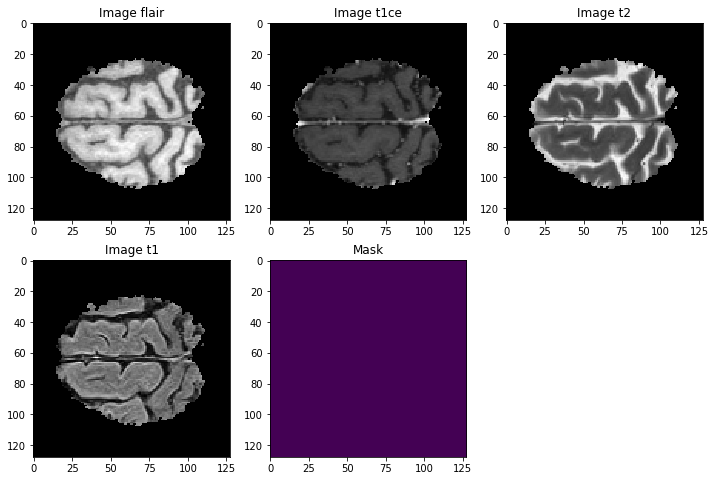

In [7]:
########################################################################
# PART 5
# 设置数据加载器

# 簇数量
batch_size = 1

train_img_data_generator = image_loader(train_img_dir, train_img_list,
                                        train_mask_dir, train_mask_list, batch_size)

val_img_data_generator = image_loader(val_img_dir, val_img_list,
                                      val_mask_dir, val_mask_list, batch_size)

# 测试加载
img, msk = next(train_img_data_generator)

img_num = random.randint(0, img.shape[0] - 1)
test_img = img[img_num]
test_mask = msk[img_num]
test_mask = np.argmax(test_mask, axis=3)

n_slice = random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_img[:, :, n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_img[:, :, n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(233)
plt.imshow(test_img[:, :, n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(234)
plt.imshow(test_img[:, :, n_slice, 3], cmap='gray')
plt.title('Image t1')
plt.subplot(235)
plt.imshow(test_mask[:, :, n_slice])
plt.title('Mask')
plt.show()

In [6]:
########################################################################
# PART 6
# 设置损失函数，优化器，学习率
# Define loss, metrics and optimizer to be used for training
# 运行
# pip install segmentation-models-3D
# pip install keras_applications==1.0.8 --no-deps
# pip install keras_preprocessing==1.1.2 --no-deps
# 已经计算好
# wt0, wt1, wt2, wt3 = (0.26, 33.8, 33.8, 24.87)
import segmentation_models_3D as sm

# import tensorflow as tf

# dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3]))
# focal_loss = tf.keras.losses.CategoricalCrossentropy()
# total_loss = dice_loss + (1 * focal_loss)

# metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

# LR = 0.0001
# optim = tf.keras.optimizers.Adam(LR)
# epoch = 2
# For my net
wt0, wt1, wt2, wt3 = (0.26, 33.8, 33.8, 24.87)
import model.modality_pairing_net as MPN
from loss_function import main_loss_function, aux_loss_function
import tensorflow as tf

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]
total_loss = [main_loss_function, aux_loss_function]

LR = 0.01
optim = tf.keras.optimizers.SGD(learning_rate=LR, momentum=0.9)
epoch = 2

Segmentation Models: using `tf.keras` framework.


In [9]:
########################################################################
# PART 6
# save model
import time
import datetime
import os

t = time.localtime()

model_folder = "./save_model"
if not os.path.exists(model_folder):
    os.mkdir(model_folder)

model_type = "brats3dunet"
model_create_time = f"{t.tm_year}{t.tm_mon}{t.tm_mday}{t.tm_hour}{t.tm_min}"
model_sample_count = len(train_img_list)
model_batch = batch_size
model_epoch = epoch
model_extention = ".hdf5"
model_checkpoints_path = "checkpoints"
# Set save info
model_name = f"model_{model_type}_{model_create_time}_{model_sample_count}sample_{model_batch}batch_{model_epoch}epoch"
# Set log
if not os.path.exists('./logs'):
    os.mkdir('./logs')
if not os.path.exists('./logs/profile/'):
    os.mkdir('./logs/profile/')
log_dir = "logs/profile/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

2021-10-27 04:42:31.448388: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 04:42:31.448453: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 04:42:31.448537: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2021-10-27 04:42:31.449226: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory
2021-10-27 04:42:31.449497: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so'; dlerror: libcupti.so: cannot open shared object file: No such file or directory
2021-10-27 04:42:31.449560: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be 

In [ ]:
########################################################################
# PART 6
# 训练模型
# Fit the model
import pandas as pd
import numpy as np

# 确保使用GPU
physical_gpus = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_virtual_device_configuration(
    physical_gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=20 * 1000)]
)
logical_gpus = tf.config.list_logical_devices("GPU")
# 地板除得出epoch数量
steps_per_epoch = len(train_img_list) // batch_size
val_steps_per_epoch = len(val_img_list) // batch_size

# 加载模型
# from model.simple_3d_unet import simple_unet_model

# model = simple_unet_model(IMG_HEIGHT=128,
#                           IMG_WIDTH=128,
#                           IMG_DEPTH=128,
#                           IMG_CHANNELS=4,
#                           num_classes=4)
tf.keras.backend.clear_session()
model = MPN.get_main_net()
# 编译模型
model.compile(optimizer=optim, loss=total_loss, metrics=metrics)
print(model.summary())

print(model.input_shape)
print(model.output_shape)

# Save model and checkpoint
os.mkdir(f"{model_folder}/{model_name}")
os.mkdir(f"{model_folder}/{model_name}/{model_checkpoints_path}")
# Include the epoch in the file name (uses `str.format`)
checkpoint_dir = f"{model_folder}/{model_name}/{model_checkpoints_path}"
checkpoint_path = checkpoint_dir + "/cp-{epoch:04d}.ckpt"

# if recover from a checkpoint
# last_checkpoint_path = ""
# model.load_weights(last_checkpoint_path)


# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=5 * batch_size)

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# 输出结果
history = model.fit(train_img_data_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epoch,
                    verbose=1,
                    validation_data=val_img_data_generator,
                    validation_steps=val_steps_per_epoch,
                    callbacks=[cp_callback, tensorboard_callback],
                    )

# 模型保存
# create folder
# models
#  - model...
#    - model_name
#    - checkpoint
#    - history
#    - pic
model.save(f"{model_folder}/{model_name}/{model_name}{model_extention}")

# save history
save = pd.DataFrame(data=history.history)
save.to_csv(f"{model_folder}/{model_name}/history.csv")

# plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Model: "modality_pairing_net_train"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 12 0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 128, 128, 128 0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 128, 128, 128 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 128, 128, 128 1760        tf.__operators__.getitem_1[0][0] 
_________________________________________________________________________

2021-10-27 04:42:46.909471: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2
y_true dice TensorShape([None, None, None, None, None])
y_pred dice TensorShape([None, 128, 128, 128, 4])


2021-10-27 04:43:00.115408: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2021-10-27 04:43:00.997682: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Running ptxas --version returned 32512
2021-10-27 04:43:01.094888: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2021-10-27 04:43:16.713493: W tensorflow/core/common_runtime/bfc_allocator.cc:457] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.00GiB (rounded to 1073741824)requested by op modality_pairing_net_train/conv3d_11/Conv3D
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2021-10-27 0

In [ ]:
print(tf.config.experimental.list_physical_devices('GPU'))
tf.__version__